## Sandwich_profile_metrics
This notebook explores processing profiles.

This is material copied from the end of Sandwich_analyze_ROI. These are experiments in processing transects, but don't run yet...they need the packages and data.

In [62]:
import numpy as np
#import  json
# from  shapely.geometry  import Polygon, Point
# import shapely.ops as shops
# #from descartes.patch import PolygonPatch
# import shapely.vectorized
# from datetime import datetime
# import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
#import hvplot.xarray
import pandas as pd
#from IPython.display import display, HTML
from scipy import interpolate, signal, stats
from astropy.convolution import Gaussian1DKernel, Box1DKernel, Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve as astropy_convolve
%matplotlib inline

In [112]:
# list of dates for use as titles / column headers
titles = ([\
         "22-Jan-2016",\
         "25-Jan-2016",\
         "11-Feb-2016",\
         "30-Mar-2016",\
         "21-Sep-2016",\
         "09-Jan-2017",\
         "25-Jan-2017",\
         "14-Feb-2017",\
         "16-Mar-2017",\
         "28-Apr-2017",\
         "04-May_2017",\
         "18-Sep-2017",\
         "10-Jan-2018",\
         "09-Mar-2018"])

In [73]:
def pmetrics(x, y, z, MWL=-0.2, MHW=1.28, zrange=0.3):
    """
    Find points on beach profile
    Assumes x starts somewhere offshore and is positive landward
    
    Input:
       x - distance on cross-shore profile from arbitrary point (array; m)
       y - distance alongshore (float, m) - used to customize algorithm for particular stretch of beach
       z - elevation on cross-shore profile at x locations(array same size as x, datum as MWL and MHW...normally NAVD88; m)
       MWL - elevation of mean water level (m)
       MHW - elevation of mean high water level (m)
    """
    # dict to hold result
    m = {}
    m['phi'] = np.NaN
    m['xphi'] = np.NaN    
    m['dhi'] = np.NaN
    m['xdhi'] = np.NaN
    m['xMHW']=np.NaN
    m['xMWL']=np.NaN
    m['dtoe']=np.NaN
    m['xdtoe']=np.NaN
    
    # hand-crafted max. beach widths specific to Sandwich
    bwmx = 100.
    if(y>600. and y<=1000.):
        bwmx = 50.
    if(y>1000):
        bwmx = 20.
    
    # determine spacing of profile points (assume they are uniform)
    try:
        dx = np.median(np.diff(x))
    except:
        print("Warning: problem calculating dx")
    if(np.isnan(dx)):
        print("Warning: dx = ",dx," changing to dx = 1")
        dx = 1.
    
    print("dx = ",dx)

    
    # smoothed profile
    #  size of Gauss kernal (meters)
    gkn = int(3/dx)
    #  amount to remove at ends
    gkno2 = int(round(gkn/2.))
    gauss_kernel = Gaussian1DKernel(gkn)
    zf = convolve(np.array(z), gauss_kernel)
    
    # derivatives of unsmoothed profile
    zip = np.array((0))
    dz =  np.diff( np.append(zip, z) )
    ddz = np.diff( np.append(zip, dz) )
    
    # derivative of smoothed profile
    dzf = np.diff( np.append(zip, zf))

    # eliminate big jumps
    dz[np.abs(ddz)>20.]=np.NaN
    ddz[np.abs(ddz)>20.]=np.NaN
    dzf[np.abs(dzf)>20.]=np.NaN
    
    # find highest point on profile: phi
    # max of z
    iphi = np.nanargmax(z)
    m['phi'] = z[iphi]
    m['xphi'] = x[iphi] 

    if(m['phi']>MWL):
        # we can then call dhi = phi
        m['dhi'] = z[iphi]
        m['xdhi'] = x[iphi]
        
        # find MWL by fitting line to nearby points
        idx = np.argwhere(np.logical_and(np.abs(zf-MWL)<zrange, x<175))
        if len(idx) >= 3:
            slope, intercept, r_value, p_value, stderr = \
               stats.linregress( np.squeeze(x[idx]),np.squeeze(z[idx]) )
            #print("slope, intercept, r:",slope, intercept, r_value)
            xMWL = (MWL-intercept)/slope
            if np.any(x<=xMWL):
                iMWL = np.argwhere(x<=xMWL)[-1]
                m['xMWL']=xMWL

        # find MHW the same way
        if(m['phi']>MHW):
            idx = np.argwhere(np.logical_and(np.abs(zf-MHW)<zrange, x<175))
            if len(idx) >= 3:
                slope, intercept, r_value, p_value, stderr = \
                   stats.linregress( np.squeeze(x[idx]),np.squeeze(z[idx]) )
                #print("slope, intercept, r:",slope, intercept, r_value)
                xMHW = (MHW-intercept)/slope
                if np.any(x<=xMHW):
                    iMHW = np.asscalar(np.argwhere(x<=xMHW)[-1])
                    m['xMHW']=xMHW

                    # dune toe = max ddz between MHW and 30 m
                    idtoe = iMHW+np.nanargmax(ddz[iMHW:iMHW+int(30/dx)])-2
                    m['dtoe'] = z[idtoe]
                    m['xdtoe'] = x[idtoe]
    
    m['bslope']=np.nan
    if(~np.isnan(m['xMHW']) and ~np.isnan(m['xMWL'])):
        # beach slope between MWL and MHW
        m['bslope'] = (MHW-MWL)/(xMHW-xMWL)
    
    return m

def hmetrics( z, dx=1., dy=1.):
    """
    Calculate horizontal metrics in DEM coordiante
    
    Peckham, S.D., 'Profile, Plan and Streamline Curvature: A Simple Derivation and Applications'
    Geomorphometery.org/2011.
    https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=8&cad=rja&uact=8&ved=2ahUKEwinl86vkKDgAhVQxVkKHaEVBlMQFjAHegQIARAC&url=https%3A%2F%2Fwww.geomorphometry.org%2Fsystem%2Ffiles%2FPeckham2011ageomorphometry.pdf&usg=AOvVaw1iq3Zz0N3fHhBDgi_jXD-R
    TODO: Check varying dx and dy. I think that is as simple as multipying the
          returned gradients by dx and dy.
    TOTO: Check plan curvature. Looks too noisy.
          
    Input:
       z - Elevation matrix with 
    """
    fy, fx = np.gradient( z )
    fy = fy*dy
    fx = fx*dx
    
    slope = np.sqrt(fx**2 + fy**2)
    #  slope = np.pi/2. - np.arctan(slope_mag) # angle in radians
    aspect = np.rad2deg( np.arctan2( -fx, -fy) )
    
    fxy, fxx = np.gradient(fx)
    fyy, fyx = np.gradient(fy)
    fxy = fxy*dy
    fxx = fxx*dx
    fyy = fyy*dy
    fyx = fyx*dx
    
    # profile curvature
    kp = (fx**2.*fxx + 2.*fx*fy*fxy + fy**2*fyy)/(-slope**2)
    # plan curvature
    kc = (fy**2.*fxx - 2.*fx*fy*fxy + fx**2*fyy)/(-slope**3)
    
    return slope, aspect, kp, kc

def map_stats3d(mp):
    '''
    Calculate some basic statistics for 3D map arrays
    '''
    mean = np.nanmean(mp,axis=(1,2))
    mad = np.nanmean(np.abs(mp),axis=(1,2))
    dmin = np.nanmin(mp,axis=(1,2))
    dmax = np.nanmax(mp,axis=(1,2))
    rms = np.sqrt(np.nanmean(mp**2.,axis=(1,2)))
    s = np.shape(mp)
    num = []
    numn = []
    for i in range(s[0]):
       num.append(mp[i,:,:].size)
       numn.append(np.count_nonzero(np.isnan(mp[i,:,:])))
    print("Shape: ",s)
    print("mean",mean)
    print("mad",mad)
    print("min",dmin)
    print("max",dmax)
    print("rms",rms)
    print("nans",numn)
    print("size",num)
    return mean, mad

def map_stats2d(mp):
    '''
    Calculate some basic statistics for 2D map arrays
    '''
    mean = np.nanmean(mp,axis=(0,1))
    mad = np.nanmean(np.abs(mp),axis=(0,1))
    dmin = np.nanmin(mp,axis=(0,1))
    dmax = np.nanmax(mp,axis=(0,1))
    rms = np.sqrt(np.nanmean(mp**2.,axis=(0,1)))
    s = np.shape(mp)
    num = (mp[:,:].size)
    numn = (np.count_nonzero(np.isnan(mp[:,:])))
    print("Shape: ",s)
    print("mean",mean)
    print("mad",mad)
    print("min",dmin)
    print("max",dmax)
    print("rms",rms)
    print("nans",numn)
    print("size",num)
    return mean, mad

In [108]:
da = xr.open_dataarray('Sandwich_1m_DEM_v2.nc')
(nmaps,ysize,xsize)=np.shape(da.values)
print('Shape of stacked elevation array: ',nmaps,ysize,xsize)

# use meshgrid to make coordinate arrays
X, Y = np.meshgrid( da.coords['Alongshore'], da.coords['Cross-shore'].values )
print('Shape of X and Y',np.shape(X),np.shape(Y))

# convert dataArry to np array, and change missing values to NaNs
zmap = np.array( da.values.copy() )
zmap[zmap <= -1.]=np.NaN

Shape of stacked elevation array:  14 280 1300
Shape of X and Y (280, 1300) (280, 1300)


C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\IOOS\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()


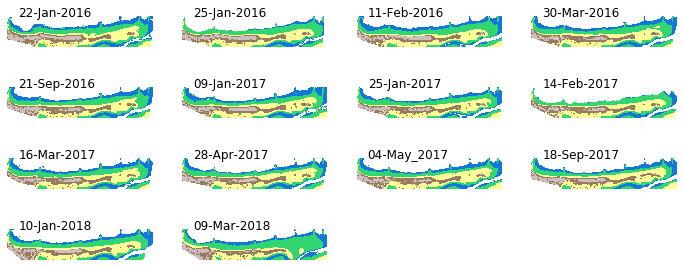

In [113]:
# declare a plot size
clevels = [-2,0,2,4,6,8]
fig  = plt.figure(figsize=(12,5))
for i in range(nmaps):
# small plots of elevation
    ax=fig.add_subplot(4,4,i+1)
    plt.axis('off')
    plt.contourf(X,Y,np.squeeze(zmap[i,:,:]),clevels,cmap=plt.cm.terrain)
    plt.text(100,270,titles[i],fontsize=12)
    ax.set_aspect(1.);

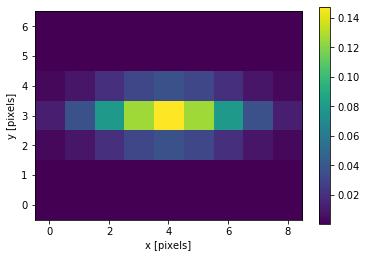

In [114]:
# smooth the maps using the scipy filter, which will enlarge regions of NaNs. But use anisotropic, sharp Gaussian kernal.
gaussian_2D_kernel = Gaussian2DKernel(1.8, .6, theta=0., x_size=9, y_size=7)
plt.imshow(gaussian_2D_kernel, interpolation='none', origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()
print(gaussian_2D_kernel)

In [115]:
smap=np.nan*np.ones_like(zmap)
for imap in range(nmaps):
    smap[imap,:,:] = scipy_convolve(np.squeeze(zmap[imap,:,:]), gaussian_2D_kernel, mode='same', method='direct')

map_stats3d(smap)

Shape:  (14, 280, 1300)
mean [2.04456506 2.32305053 1.85650077 1.92908838 1.94542956 1.94126519
 2.01274259 2.31348146 1.9404115  2.12647541 2.01716187 2.0683289
 1.99944789 1.73224538]
mad [2.20294026 2.38562339 2.0286734  2.09415721 2.11760815 2.13139791
 2.1378243  2.38958797 2.10813663 2.25311722 2.17739593 2.2359448
 2.15291839 1.86421157]
min [-0.95230205 -0.89201155 -0.95932622 -0.95727388 -0.96604671 -0.95043099
 -0.93379947 -0.9671924  -0.95693544 -0.96190823 -0.9604977  -0.94443094
 -0.96899898 -0.94079127]
max [13.26432917 13.45790134 13.85925032 13.50111481 13.37163394 13.65212686
 13.77921032 13.42294833 13.36961591 13.55004087 13.38760345 13.552305
 14.33715776 14.97940948]
rms [2.84941083 2.99729917 2.71342585 2.71859752 2.76360169 2.75932691
 2.74223542 2.92116186 2.69740515 2.86701282 2.77703859 2.8562391
 2.78996264 2.56787961]
nans [146354, 175761, 141032, 149734, 149747, 151660, 168151, 187381, 163236, 171416, 154638, 162712, 154798, 147845]
size [364000, 364000, 36

(array([2.04456506, 2.32305053, 1.85650077, 1.92908838, 1.94542956,
        1.94126519, 2.01274259, 2.31348146, 1.9404115 , 2.12647541,
        2.01716187, 2.0683289 , 1.99944789, 1.73224538]),
 array([2.20294026, 2.38562339, 2.0286734 , 2.09415721, 2.11760815,
        2.13139791, 2.1378243 , 2.38958797, 2.10813663, 2.25311722,
        2.17739593, 2.2359448 , 2.15291839, 1.86421157]))

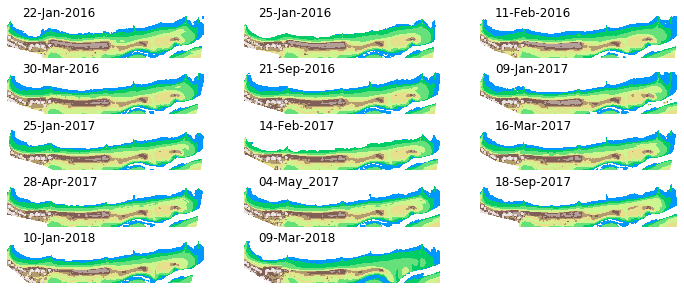

In [127]:
# plot the maps
clevels = [-2,-1,0,1,2,3,4,5,6,7,8]

fig  = plt.figure(figsize=(12,5))
for i in range(nmaps):
# small plots of elevation
    ax=fig.add_subplot(5,3,i+1)
    plt.axis('off')
    plt.contourf(X,Y,np.squeeze(smap[i,:,:]),clevels,cmap=plt.cm.terrain)
    plt.text(100,270,titles[i],fontsize=12)
    ax.set_aspect(1.);

In [121]:
# calculate difference maps
dmap = np.diff(smap,n=1,axis=0)
print(np.shape(dmap))

(13, 280, 1300)


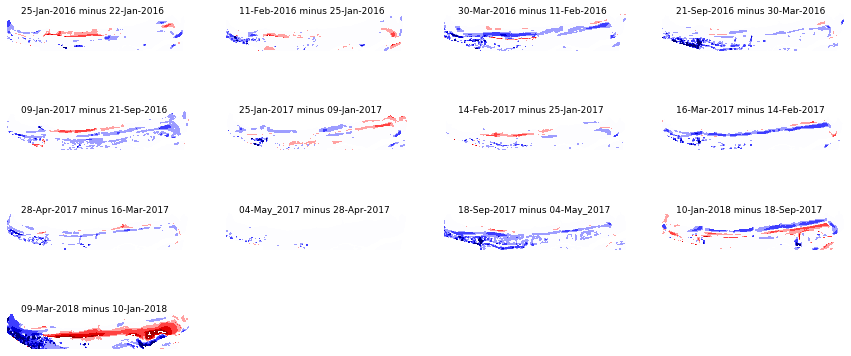

In [125]:
# plot the maps
dclevels = [-2,-1.5,-1,-0.5,-.25,.25,.5,1.,1.5,2]
fig  = plt.figure(figsize=(15,7))
for i in range(nmaps-1):
# small plots of elevation
    ax=fig.add_subplot(4,4,i+1)
    plt.axis('off')
    plt.contourf(X,Y,np.squeeze(dmap[i,:,:]),dclevels,cmap=plt.cm.seismic_r)
    plt.text(100,270,titles[i+1]+' minus '+titles[i],fontsize=9)
    ax.set_aspect(1.);

In [38]:
# calculate slope and aspect
# TODO - these should be calculated on a smoothed map
slope = np.nan*np.ones(np.shape(da.values))
aspect = np.nan*np.ones(np.shape(da.values))
kp = np.nan*np.ones(np.shape(da.values))
kc = np.nan*np.ones(np.shape(da.values))

for imap in range(nmaps):
    smap = astropy_convolve(np.squeeze(da[imap,:,:]), gaussian_2D_kernel)
    slope[imap,:,:], aspect[imap,:,:], kp[imap,:,:], kc[imap,:,:] = hmetrics( smap )

C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\IOOS\lib\site-packages\ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in true_divide
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\IOOS\lib\site-packages\ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in true_divide


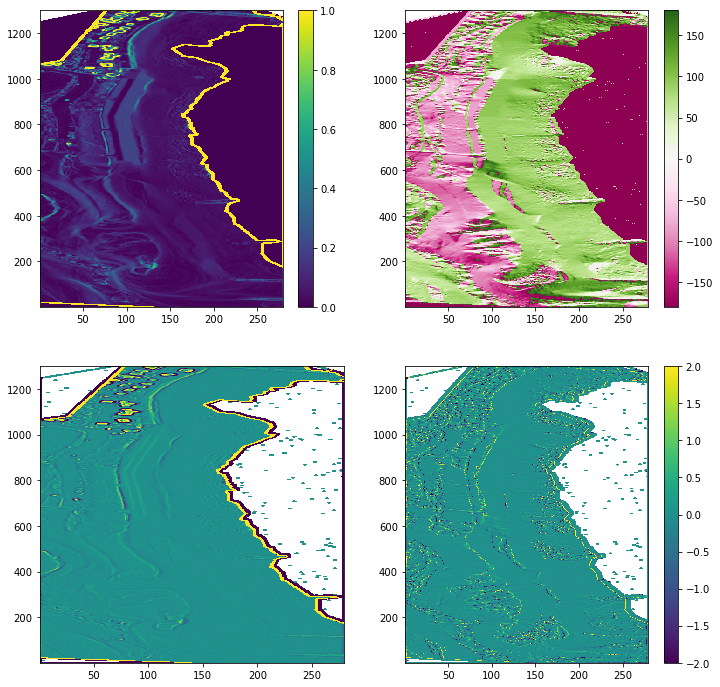

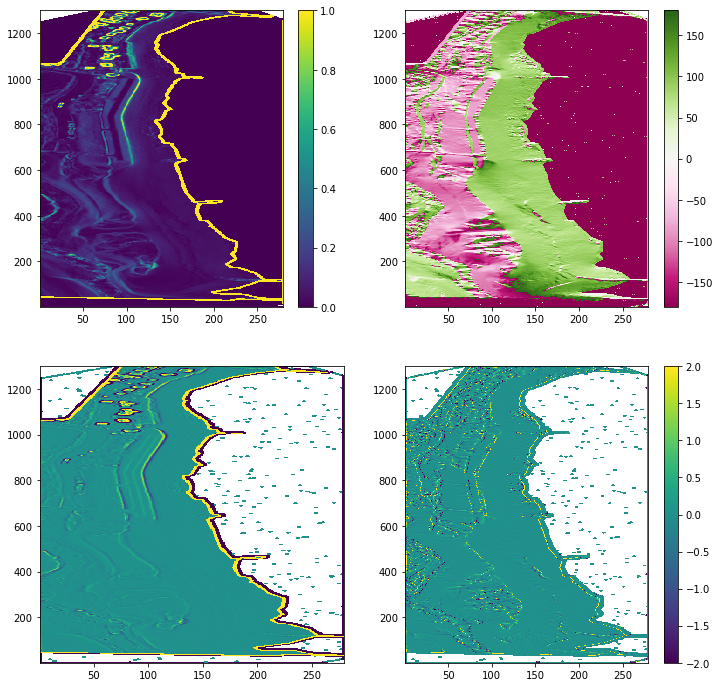

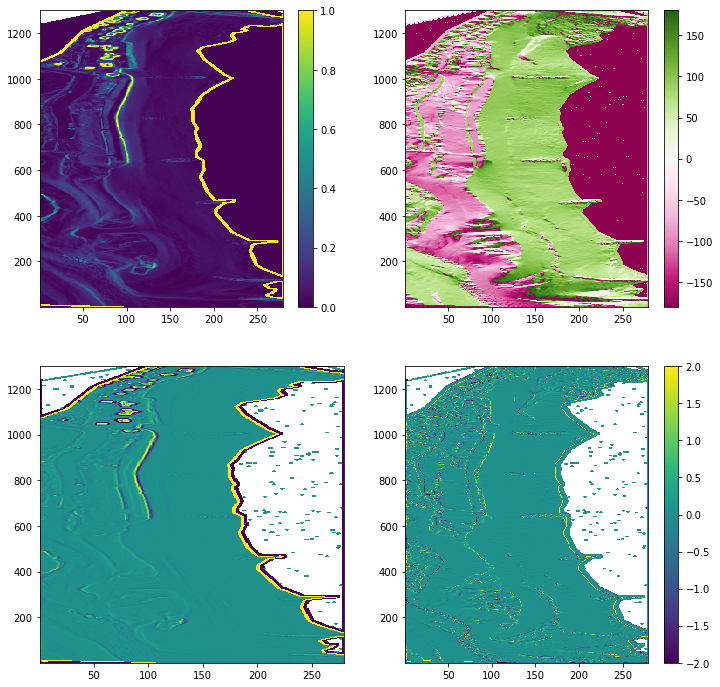

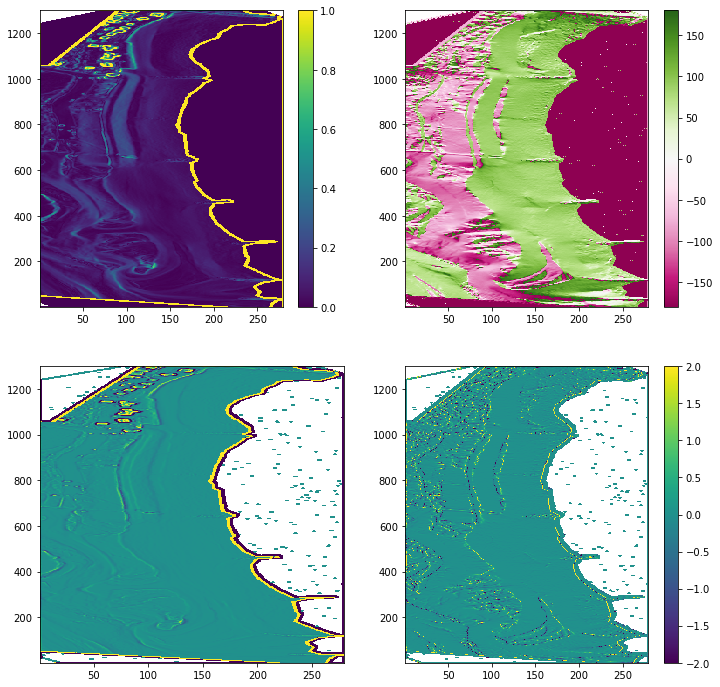

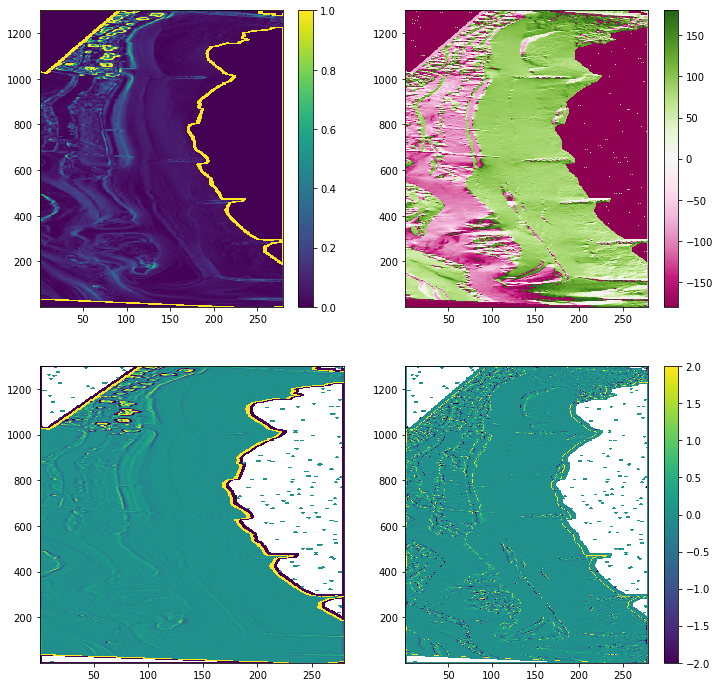

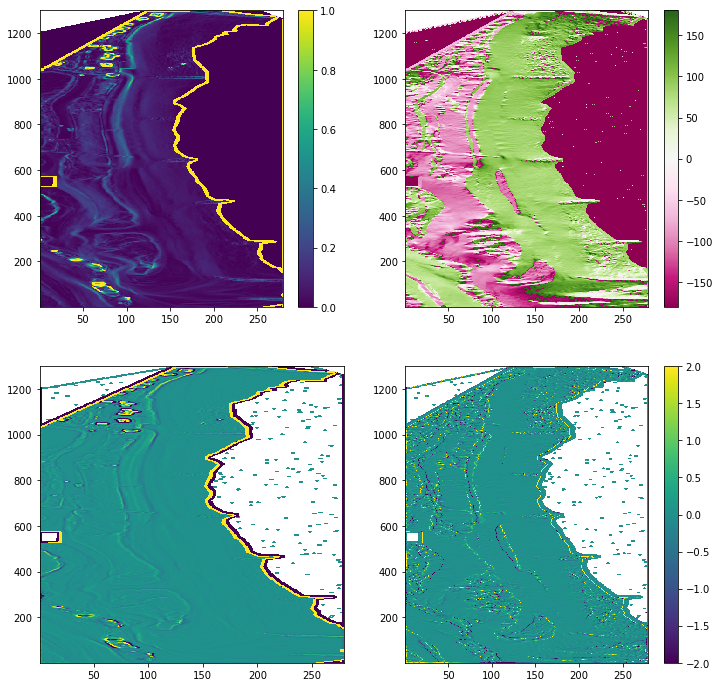

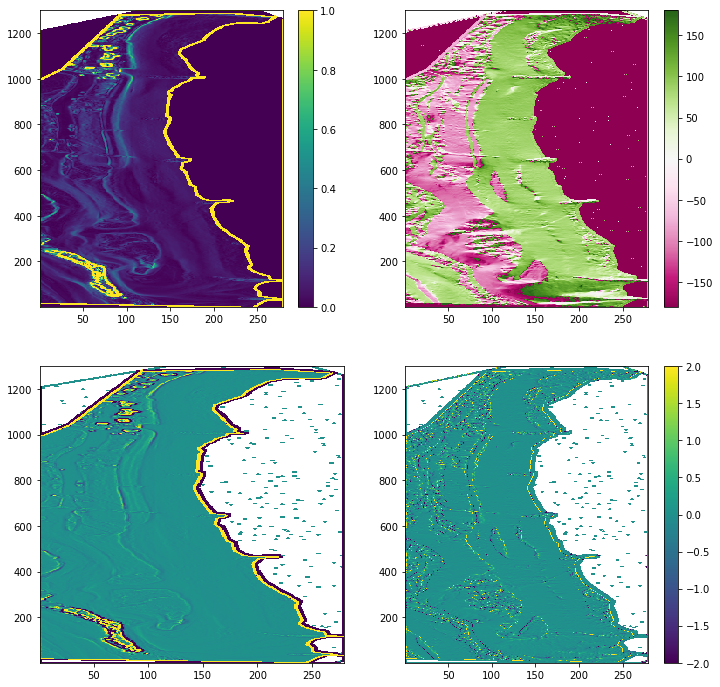

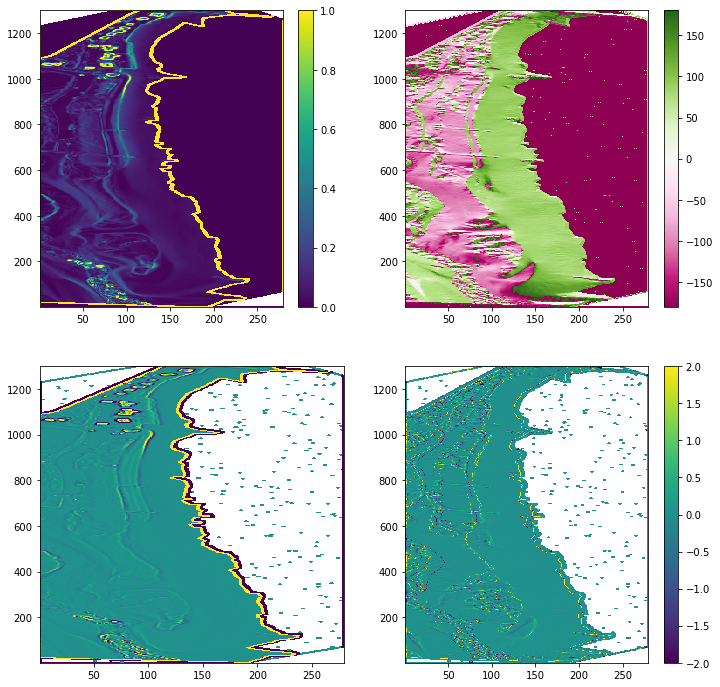

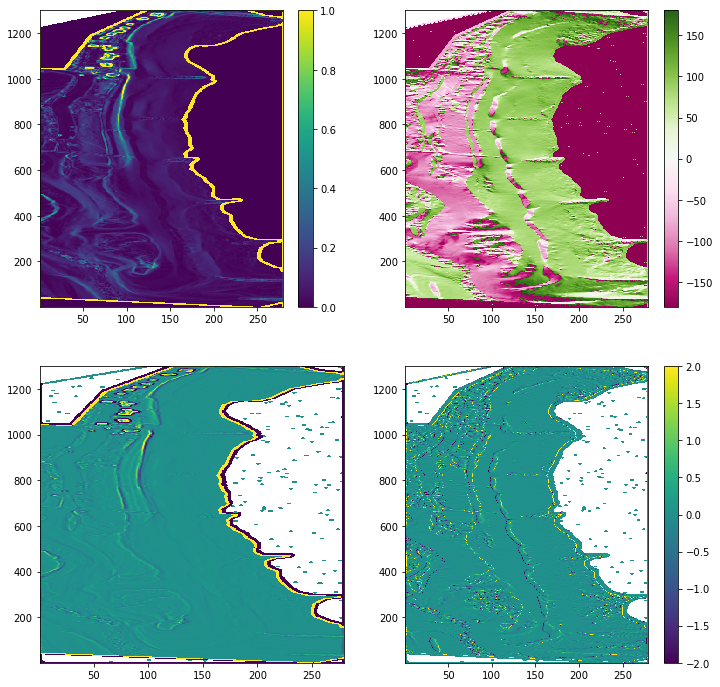

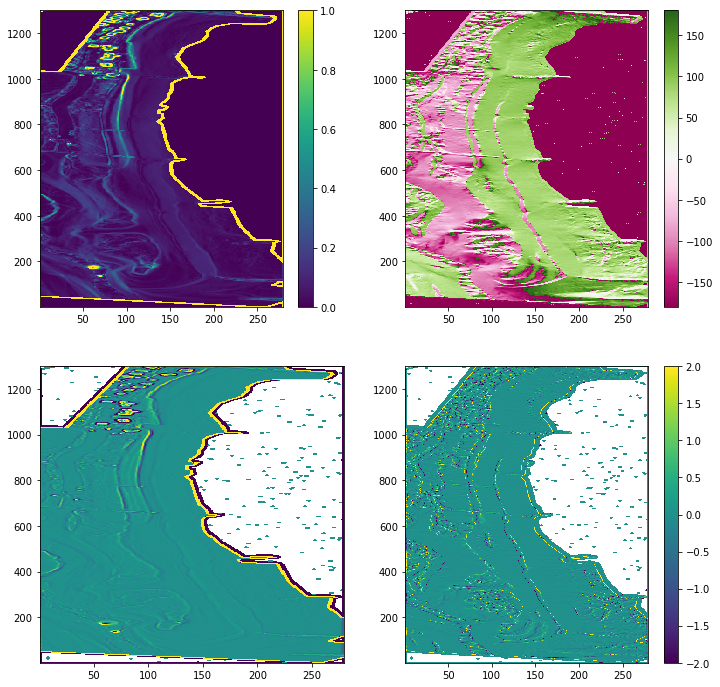

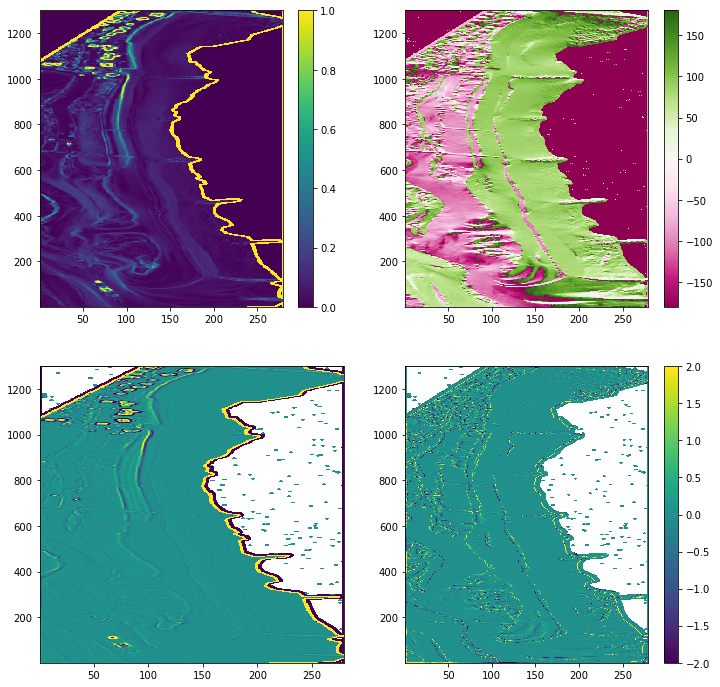

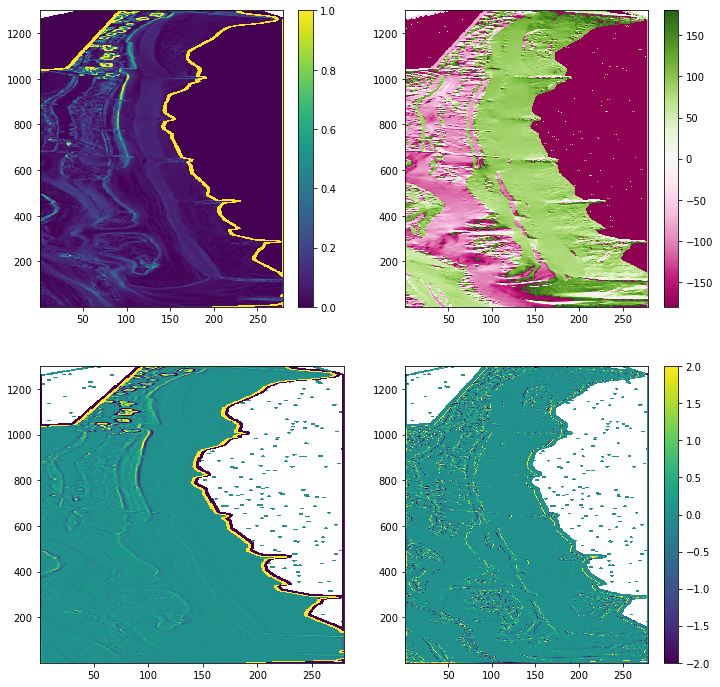

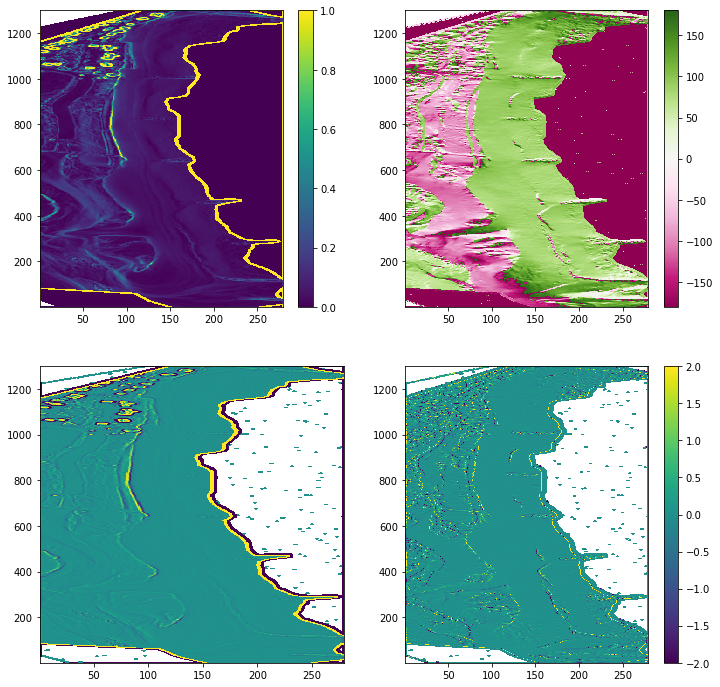

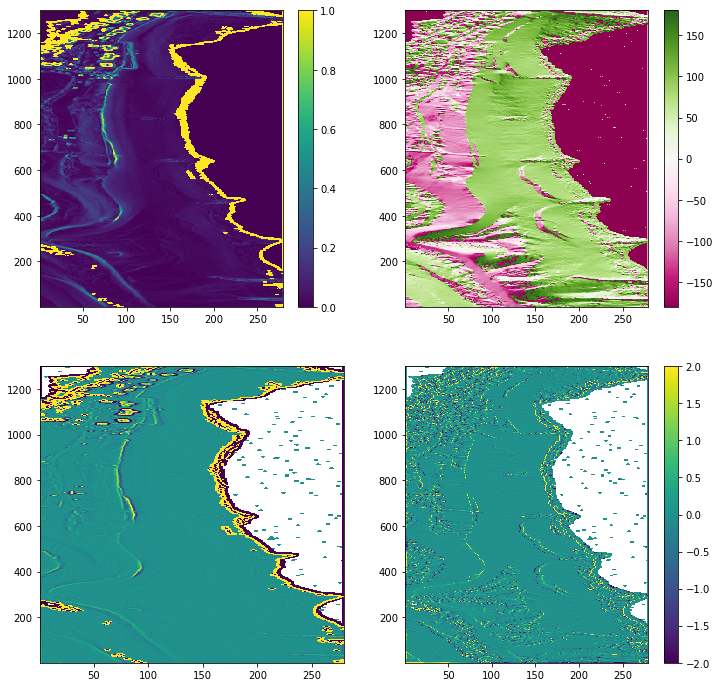

In [39]:
for imap in range(nmaps):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(221)
    plt.pcolormesh(X,Y,np.squeeze(slope[imap,:,:]),vmin=0,vmax=1.)
    plt.colorbar()
    ax = fig.add_subplot(222)
    plt.pcolormesh(X,Y,np.squeeze(aspect[imap,:,:]),vmin=-180.,vmax=180.,cmap=plt.cm.PiYG)
    plt.colorbar()
    ax = fig.add_subplot(223)
    plt.pcolormesh(X,Y,np.squeeze(kp[imap,:,:]),vmin=-.5,vmax=+.5)
    ax = fig.add_subplot(224)
    plt.pcolormesh(X,Y,np.squeeze(kc[imap,:,:]),vmin=-2,vmax=2)
    plt.colorbar();

In [12]:
# Get a profile for testing
imap = 7;
iy=800
x =da.coords['Cross-shore'].values
z =da[imap,iy,:].values
dx = np.median(np.diff(x))
print(x,dx)

[  0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5
  12.5  13.5  14.5  15.5  16.5  17.5  18.5  19.5  20.5  21.5  22.5  23.5
  24.5  25.5  26.5  27.5  28.5  29.5  30.5  31.5  32.5  33.5  34.5  35.5
  36.5  37.5  38.5  39.5  40.5  41.5  42.5  43.5  44.5  45.5  46.5  47.5
  48.5  49.5  50.5  51.5  52.5  53.5  54.5  55.5  56.5  57.5  58.5  59.5
  60.5  61.5  62.5  63.5  64.5  65.5  66.5  67.5  68.5  69.5  70.5  71.5
  72.5  73.5  74.5  75.5  76.5  77.5  78.5  79.5  80.5  81.5  82.5  83.5
  84.5  85.5  86.5  87.5  88.5  89.5  90.5  91.5  92.5  93.5  94.5  95.5
  96.5  97.5  98.5  99.5 100.5 101.5 102.5 103.5 104.5 105.5 106.5 107.5
 108.5 109.5 110.5 111.5 112.5 113.5 114.5 115.5 116.5 117.5 118.5 119.5
 120.5 121.5 122.5 123.5 124.5 125.5 126.5 127.5 128.5 129.5 130.5 131.5
 132.5 133.5 134.5 135.5 136.5 137.5 138.5 139.5 140.5 141.5 142.5 143.5
 144.5 145.5 146.5 147.5 148.5 149.5 150.5 151.5 152.5 153.5 154.5 155.5
 156.5 157.5 158.5 159.5 160.5 161.5 162.5 163.5 16

In [4]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(211)
plt.plot(x,z)
plt.plot(kp[i,:],'--')
plt.grid()
ax = fig.add_subplot(212)
plt.plot(slope[i,:])
plt.plot(kp[i,:],'--')
plt.grid();

IndexError: index 800 is out of bounds for axis 0 with size 280

In [48]:
import warnings
warnings.filterwarnings('ignore')

# cross-shore coordinates are positive toward ocean...flip them around
itransect = 80
imap=3
MWL=-0.2
MHW=1.28

nmaps,ntransects,ncross = np.shape(da)

ma = np.empty([nmaps,900,5])

for imap in range(nmaps):
    slope, aspect, kp, kc = hmetrics( da[imap,:,:].values )

    for i, itransect in enumerate(range(200,1100)):
        z = np.flip( da[imap,itransect,:].values, 0 )
        x = np.flip( da.coords['Cross-shore'].values, 0)
        a = np.flip( aspect[itransect], 0)
        # reverse x-axis direction...now starts some arbitrary distance offshore
        xr = np.max(x)-x
        m = pmetrics(xr,i,z,a,MWL,MHW)
        ma[imap,i,:]=np.array([ m['xMWL'],m['xMHW'],m['xdtoe'],m['dtoe'],m['bslope']])


(14, 900, 5)
1000.5


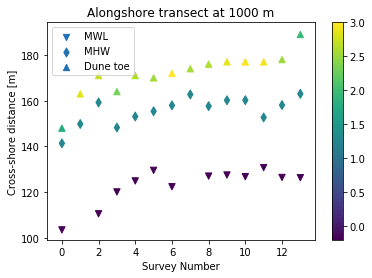

In [83]:
print(np.shape(ma))
seq_col_brew = sns.color_palette("Blues_r", 3)
sns.set_palette(seq_col_brew)


iy = 800
print(da.coords['Alongshore'].values[iy+200])
plt.scatter(range(nmaps),ma[:,iy,0],40,np.ones_like(ma[:,iy,3])*MWL,marker='v',label='MWL',vmin = -.2, vmax=3)
plt.scatter(range(nmaps),ma[:,iy,1],40,np.ones_like(ma[:,iy,3])*MHW,marker='d',label='MHW',vmin = -.2, vmax=3)
plt.scatter(range(nmaps),ma[:,iy,2],40,ma[:,iy,3],label='Dune toe',marker='^',vmin = -.2, vmax=3)
plt.colorbar()

plt.ylabel('Cross-shore distance [m]')
plt.xlabel('Survey Number')
plt.title('Alongshore transect at '+str(int(da.coords['Alongshore'].values[iy+200]))+' m')
plt.legend();

(14, 900, 5)
400.5


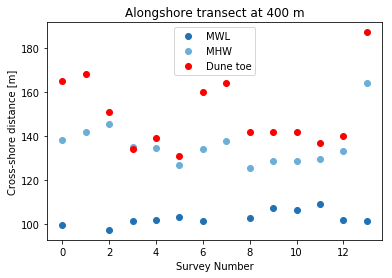

In [105]:
print(np.shape(ma))
seq_col_brew = sns.color_palette("Blues_r", 3)
sns.set_palette(seq_col_brew)


iy = 200
print(da.coords['Alongshore'].values[iy+200])
plt.plot(ma[:,iy,0],'o',label='MWL')
plt.plot(ma[:,iy,1],'o',label='MHW')
plt.plot(ma[:,iy,2],'or',label='Dune toe')

plt.ylabel('Cross-shore distance [m]')
plt.xlabel('Survey Number')
plt.title('Alongshore transect at '+str(int(da.coords['Alongshore'].values[iy+200]))+' m')
plt.legend();

Text(0.5,0,'Cross-shore distance [m]')

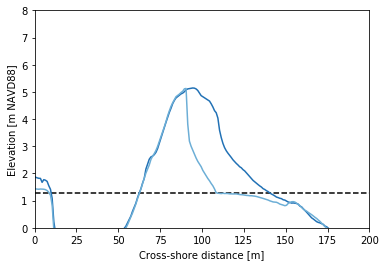

In [106]:
plt.plot(da.coords['Cross-shore'].values, MHW*np.ones_like(da.coords['Cross-shore'].values),'--k')
plt.plot(da.coords['Cross-shore'].values,da[0,iy+200,:].values)
plt.plot(da.coords['Cross-shore'].values,da[-1,iy+200,:].values)
plt.ylim((0,8))
plt.xlim((0,200))
plt.ylabel('Elevation [m NAVD88]')
plt.xlabel('Cross-shore distance [m]')



(14, 900, 5)
1000.5


ValueError: x and y must have same first dimension, but have shapes (1,) and (280,)

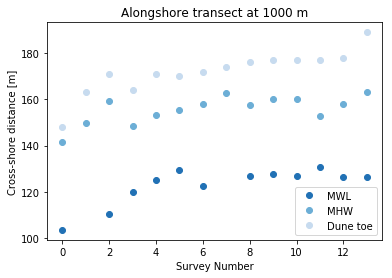

In [84]:
xmin = m['xMWL']-10
xmax = 280
cmap = 'coolwarm'

plt.plot(xr, z, '-k', alpha = .6)
plt.plot(m['xdhi'],m['dhi'],'xr')
plt.plot(m['xdtoe'],m['dtoe'],'xm')
plt.plot(m['xphi'],m['xphi'],'xc')

plt.plot(m['xMWL'],MWL,'xb')
plt.plot(m['xMHW'],MHW,'xk')

plt.ylim((-2,8))
plt.xlim((xmin,xmax))
plt.ylabel('Elev. [m]')
plt.grid(True)

In [ ]:
axarr[1].plot(xr, dzf,'-k')
axarr[1].plot(xr, fdz,'-b')
axarr[1].scatter(xr, dz,25,dz,cmap=cmap)
axarr[1].set_ylim((-.5,1.6))
axarr[1].set_xlim((xmin,xmax))
axarr[1].set_ylabel('Slope (dz/dx) [m/m]')
axarr[1].grid(True)

axarr[2].scatter(xr, ddz, 25, dz, cmap=cmap)
axarr[2].plot(xr, fddz,'-k')
axarr[2].plot(xr, ddzf)
axarr[2].plot(xr, dfdz,'-b')
#axarr[2].set_ylim((-.25,.25))
axarr[2].set_xlim((xmin,xmax))
axarr[2].set_ylabel('Change in slope (d(dz/dx)/dx [m/m2]')

axarr[2].grid(True)

# Bring subplots close to each other.
f.subplots_adjust(hspace=0.15)
# Hide x labels and tick labels for all but bottom plot.
for ax in axarr:
    ax.label_outer()

In [ ]:
# first point <= MWL
ids = np.max(np.argwhere(xr<=xrMWL))
ide = idhi
X = np.array([xr[ids:ide],z[ids:ide],np.diff( np.append(zip, z[ids:ide]) )]).T
print(np.shape(X))
weights = np.ones_like(X)
weights[0,:]*.1
weights[2,:]*10.
#kmeans = KMeans(n_clusters=4, random_state=0).fit(X,[],sample_weight=weights)
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

print(kmeans.labels_)

kmeans.cluster_centers_
plt.scatter(X[:,0],X[:,1],16,kmeans.labels_) 
kmeans.labels_

In [ ]:
MWLdatum = -0.2
imap = 13
xik = np.ones((1300,1))*np.NaN
xikb = np.ones((1300,1))*np.NaN

# extract the x coords
x = da.coords['Cross-shore'].values
y = da.coords['Alongshore'].values
for itno in range(0,1300):
    # itno = 200

    # extract a transect
    t = np.flip(np.array(da[0,itno,:]),0)

    idx = np.where(t<-100.)
    t[idx]=-10.

    # smooth w/ box (omit later?)
    box_kernel = Box1DKernel(5)
    tsb = convolve(np.array(t), box_kernel)

    # smooth w/ Gauss
    #  size of kernal
    gkn = 5
    #  amount to remove at ends
    gkno2 = int(round(gkn/2.))
    gauss_kernel = Gaussian1DKernel(gkn)
    tsg = convolve(np.array(t), gauss_kernel)
    # NaN the ends?
    # tsg[0:gkno2]=np.NaN
    # tsg[-(gkno2+1):-1]=np.NaN

    # calculate gradients (add a value to keep arrays same length)
    dts = np.append([0.],np.diff(tsg))
    ddts = np.append([1.],np.diff(dts))
    dddts = np.append([1.],np.diff(ddts))

    # look for shoreline
    #   postitive slope
    pos_slope = dts>=5e-5
    #   close to MWL
    close = np.abs(t-(-1.))<=0.05
    xlimit = x<150.
    kdx = np.logical_and( np.logical_and(close, pos_slope), xlimit)
    kdx1 = np.argmax(kdx)
    xik[itno]=x[kdx1]
    
    # look for back of barrier
    neg_slope = dts<=-5e-5
    xextend = x>(xik[itno]+100.)
    #print(sum(neg_slope),sum(xextend))
    kdxb = np.logical_and( np.logical_and(close, neg_slope), xextend )
    kdx2 = np.argmax(kdxb)
    #print('x[kdx2], t[kdx2] =',x[kdx2],t[kdx2]-MWLdatum)
    xikb[itno]=x[kdx2]
    #print(itno,': found ',np.sum(kdxb),' first one:', kdx2)



In [ ]:
from scipy.ndimage.filters import maximum_filter1d, median_filter
xikf = np.zeros_like(xik)
median_filter(xik, 21, output=xikf, mode='nearest')
# try several filters...use the biggest values
xikbf7= np.ones_like(xik)
xikbf21= np.ones_like(xik)
xikbf51= np.ones_like(xik)

median_filter(xikb, 7, output=xikbf7, mode='nearest')
median_filter(xikb, 21, output=xikbf21, mode='nearest')
median_filter(xikb, 51, output=xikbf51, mode='nearest')
xikbf = np.max((np.hstack((xikbf7,xikbf21,xikbf51))),axis=1)

plt.plot(xik)
plt.plot(xikf,'.k')
plt.plot(xikb,'-b')
plt.plot(xikbf,'.c')
plt.xlim(400, 600)

In [ ]:
da.isel(map=imap).plot(vmin=-2,vmax=8,cmap=plt.cm.terrain)
plt.plot(280-xikf,y,'or')
plt.plot(180-xikf,y,'og')
plt.plot(280-xikbf,y,'oy')

In [ ]:
#   first point of points closest to MWL elevation (this does not work if an inland one is closer)
# mlw =  np.argmin(np.abs(t-MWLdatum))

fig, ax = plt.subplots()
plt.plot(x,np.zeros_like(x),'--k')
plt.plot(x,t,label='Data')
plt.plot(x,tsg,label='Gauss')
# plt.plot(x,tsb,label='Box')
plt.plot(x,10*dts)
#plt.plot(x,10*ddts)
plt.plot(x[kdx],t[kdx],'ok',label='MLW')
#plt.plot(x[mlwg],t[mlwg],'ob')
ax.legend()